<a href="https://colab.research.google.com/github/iliaxant/HR_Extraction_from_Video/blob/main/HR_Extraction_from_Video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Εκτίμηση καρδιακής συχνότητας από βίντεο (πρόσωπο ή δάχτυλο) - Ψηφιακή Επεξεργασία Εικόνας**

## Εξαμηνιαία Εργασία - Ακαδημαικό έτος 2024-2025

## Ηλίας Ξανθόπουλος 58545

## GitHub Repo: https://github.com/iliaxant/HR_Extraction_from_Video

## **Μέρος 0**: Set-Up

1) Mounting του Google drive και φόρτωση ενός υποκειμένου της βάσης δεδομένων.

Αλλάξτε το zip_path ώστε να ταιριάζει με το directory του zip αρχείου.

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile

# UBFC-RPPG Dataset 2   (subject45)
zip_path = '/content/drive/MyDrive/DIP/HR_extraction/subject45.zip'
zip_ref = zipfile.ZipFile(zip_path, 'r')
zip_ref.extractall('/content')
zip_ref.close()

# UBFC-RPPG Dataset 1
zip_path = '/content/drive/MyDrive/DIP/HR_extraction/11-gt.zip'
zip_ref = zipfile.ZipFile(zip_path, 'r')
zip_ref.extractall('/content')
zip_ref.close()

print("Data unzipped successfully to /content directory.")

Data unzipped successfully to /content directory.


2) Εγκατάσταση και import βιβλιοθηκών.

In [3]:
from google.colab import drive
import zipfile
import os

import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.signal import butter, filtfilt, stft, find_peaks
from scipy.fft import fft, fftfreq

## **Μέρος 1**: Προετοιμασία Δεδομένων

1) Καθορισμός των directory όλων των δεδομένων. Τύπωση χρήσιμων πληροφοριών σχετικά με το βίντεο του υποκειμένου και τύπωση του πρώτου frame ως δείγμα.

============ Video Info ============

Resolution:       1280 x 720
Frame Rate (FPS): 30.061
Frame Count:      2569
Duration:         1:25.461 (85.461s)




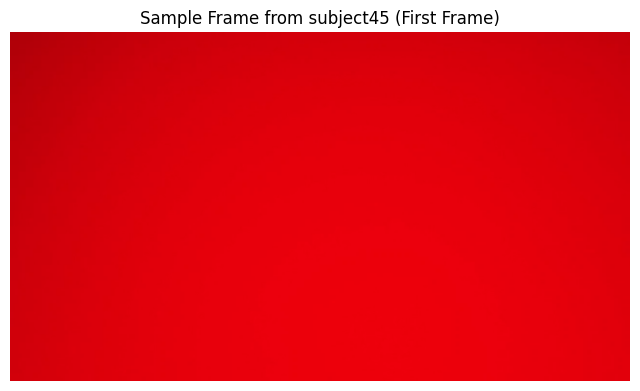

In [94]:
# Input subject num
# ------------------------------------------------

# UBFC-RPPG Dataset 2   (subject45)
num = '45'

# # UBFC-RPPG Dataset 1   (11-gt)
# num = '11'

# ------------------------------------------------


# UBFC-RPPG Dataset 2
subject_path = f'/content/subject{num}'
video_path = os.path.join(subject_path, 'vid.avi')
gt_path = os.path.join(subject_path, 'ground_truth.txt')

# # UBFC-RPPG Dataset 1
# subject_path = f'/content/{num}-gt'
# video_path = os.path.join(subject_path, 'vid.avi')
# gt_path = os.path.join(subject_path, 'gtdump.xmp')

video_path = f'/content/Ilias_finger.mp4'

cap = cv2.VideoCapture(video_path)

ret, frame_bgr = cap.read()

frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
video_duration_secs = frame_count / fps

cap.release()

frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)

minutes = int(video_duration_secs // 60)
seconds = int(video_duration_secs % 60)
milliseconds = round((video_duration_secs - int(video_duration_secs)) * 1000)

video_duration_full_time = f"{minutes}:{seconds:02d}.{milliseconds:03d}"

print("============ Video Info ============\n")

print(f"Resolution:       {width} x {height}")
print(f"Frame Rate (FPS): {fps:.3f}")
print(f"Frame Count:      {frame_count}")
print(f"Duration:         {video_duration_full_time} ({video_duration_secs:.3f}s)\n")

print("====================================\n")

plt.figure(figsize=(8, 6))
plt.imshow(frame_rgb)
plt.title(f"Sample Frame from subject{num} (First Frame)")
plt.axis('off')
plt.show()

2) Τύπωση όλων των χρήσιμων πληροφοριών για το Ground Truth. Σχεδίαση του διαγράμματος του PPG σήματος και του HR για ένα καθορισμένο χρονικό παράθυρο.

========= Ground Truth Info =========

PPG signal/Time/HR samples: 2032
Time range: 0.000s to 67.828s
Sampling rate (estimated): 29.943 Hz

PPG signal (first 10 samples): [-0.804 -0.898 -0.851 -0.772 -0.873 -1.036 -1.276 -1.452 -1.496 -1.464]
PPG signal mean: -0.000
PPG signal Standard Deviation: 0.985

Time in seconds (first 10 samples): [0.    0.033 0.066 0.099 0.132 0.165 0.202 0.233 0.275 0.297]
Difference of sampling times (first 10 values): [0.033 0.033 0.033 0.033 0.033 0.037 0.031 0.042 0.022 0.035]
Difference of sampling times mean: 0.033
Difference of sampling times Standard Deviation: 0.008

Time difference of PPG peaks (first 10 samples): [0.619 0.564 0.541 0.557 0.538 0.567 0.531 0.542 0.525 0.532]
Instantaneous Heart Rates (Hz) (first 10 samples): [1.616 1.773 1.848 1.795 1.859 1.764 1.883 1.845 1.905 1.88 ]
Instantaneous Heart Rates (bpm) (first 10 samples): [ 96.931 106.383 110.906 107.72  111.524 105.82  112.994 110.701 114.286
 112.782]

HR in bpm (first 10 samples): 

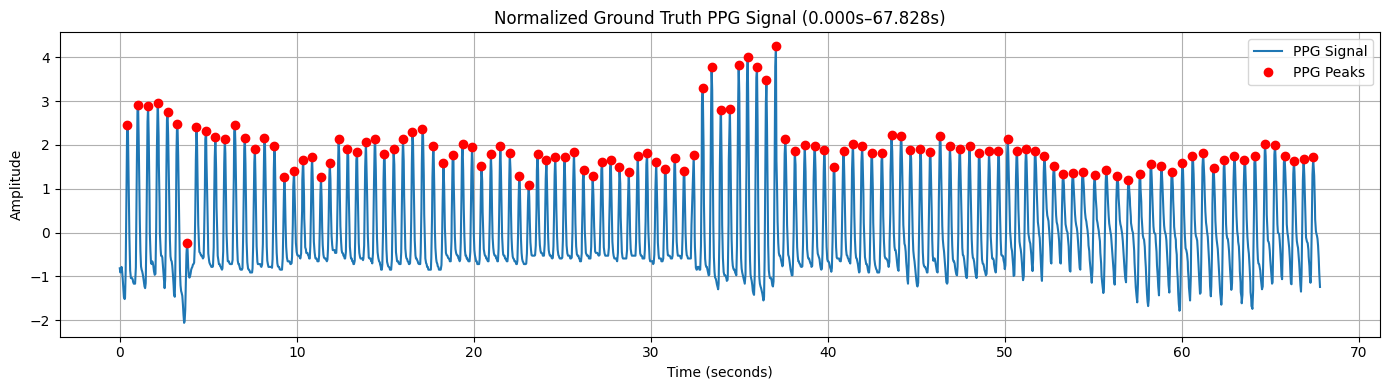

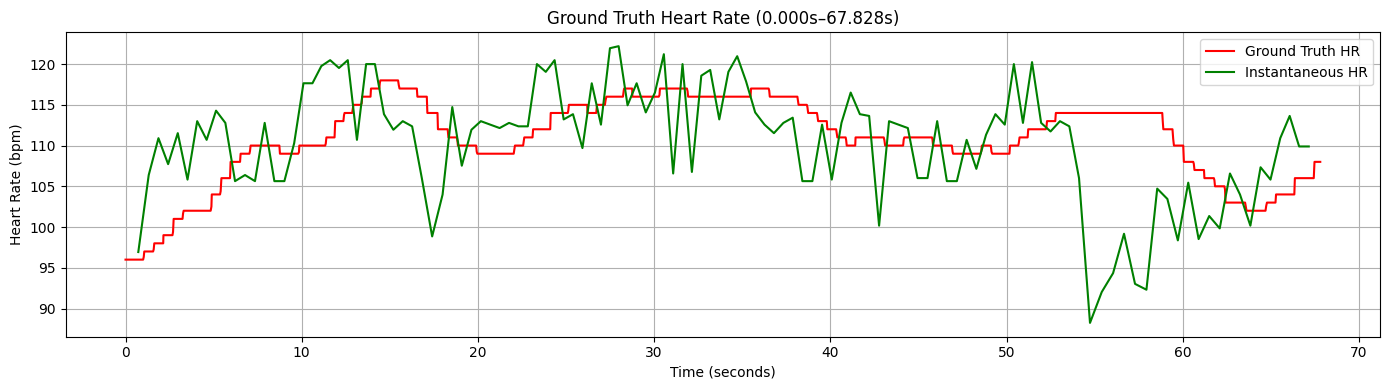

In [95]:
# UBFC-RPPG Dataset 2   (subject45)
gt_data = np.loadtxt(gt_path)
gt_ppg = gt_data[0, :]
gt_hr = gt_data[1, :]
gt_time = gt_data[2, :]


# # UBFC-RPPG Dataset 1   (11-gt)
# gt_data = np.genfromtxt(gt_path, delimiter=',')
# gt_ppg = gt_data[:, 3]
# gt_hr = gt_data[:, 1]
# gt_time = gt_data[:, 0] / 1000.0



# Input start time and duration (in seconds) for PPG signal and HR plot.
# ------------------------------------------------
start_time = 0
segment_duration = gt_time[-1]    # Signal lasts gt_time[-1] seconds.
# ------------------------------------------------


end_time = start_time + segment_duration
start_time = np.clip(start_time, 0, gt_time[-1])
end_time = np.clip(end_time, 0, gt_time[-1])

start_samp = np.searchsorted(gt_time, start_time)
end_samp = np.searchsorted(gt_time, end_time)

gt_ppg_norm= (gt_ppg - np.mean(gt_ppg)) / np.std(gt_ppg)
gt_ppg_peaks, gt_ppg_peaks_props = find_peaks(gt_ppg_norm,prominence=0.5)
gt_ppg_peak_times = gt_time[gt_ppg_peaks]

gt_samp_time_diff = np.diff(gt_time)
gt_peak_time_diff = np.diff(gt_ppg_peak_times)

instantaneous_hr_hz = 1 / gt_peak_time_diff
instantaneous_hr_bpm = instantaneous_hr_hz * 60

gt_ppg_peaks_filt = gt_ppg_peaks[
    (gt_time[gt_ppg_peaks] >= start_time) &
    (gt_time[gt_ppg_peaks] <= end_time)
]

instantaneous_hr_times = (gt_ppg_peak_times[1:] + gt_ppg_peak_times[:-1]) / 2
hr_time_mask = (instantaneous_hr_times >= start_time) & (instantaneous_hr_times <= end_time)
instantaneous_hr_times_filt = instantaneous_hr_times[hr_time_mask]
instantaneous_hr_bpm_filt = instantaneous_hr_bpm[hr_time_mask]


print("========= Ground Truth Info =========\n")

print(f"PPG signal/Time/HR samples: {len(gt_ppg)}")
print(f"Time range: {gt_time[0]:.3f}s to {gt_time[-1]:.3f}s")
print(f"Sampling rate (estimated): {1/np.mean(np.diff(gt_time)):.3f} Hz\n")

print(f"PPG signal (first 10 samples): {np.round(gt_ppg[:10], 3)}")
print(f"PPG signal mean: {np.mean(gt_ppg):.3f}")
print(f"PPG signal Standard Deviation: {np.std(gt_ppg):.3f}\n")

print(f"Time in seconds (first 10 samples): {gt_time[:10]}")
print(f"Difference of sampling times (first 10 values): {gt_samp_time_diff[:10]}")
print(f"Difference of sampling times mean: {np.mean(gt_samp_time_diff):.3f}")
print(f"Difference of sampling times Standard Deviation: {np.std(gt_samp_time_diff):.3f}\n")

print(f"Time difference of PPG peaks (first 10 samples): {gt_peak_time_diff[:10]}")
print(f"Instantaneous Heart Rates (Hz) (first 10 samples): {np.round(instantaneous_hr_hz[:10], 3)}")
print(f"Instantaneous Heart Rates (bpm) (first 10 samples): {np.round(instantaneous_hr_bpm[:10], 3)}\n")

print(f"HR in bpm (first 10 samples): {gt_hr[:10].astype(int)}")
print(f"HR mean: {np.mean(gt_hr):.3f}")
print(f"HR Standard Deviation: {np.std(gt_hr):.3f}\n")

print("=====================================\n")


plt.figure(figsize=(14, 4))
plt.plot(gt_time[start_samp:end_samp], gt_ppg_norm[start_samp:end_samp],
         label="PPG Signal")
plt.plot(gt_time[gt_ppg_peaks_filt], gt_ppg_norm[gt_ppg_peaks_filt], 'o',
         color = 'r', label="PPG Peaks")
plt.title(f"Normalized Ground Truth PPG Signal ({start_time:.3f}s–{end_time:.3f}s)")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 4))
plt.plot(gt_time[start_samp:end_samp], gt_hr[start_samp:end_samp], color='r',
         label = 'Ground Truth HR')
plt.plot(instantaneous_hr_times_filt, instantaneous_hr_bpm_filt, color='g',
         label = 'Instantaneous HR')
plt.title(f"Ground Truth Heart Rate ({start_time:.3f}s–{end_time:.3f}s)")
plt.xlabel("Time (seconds)")
plt.ylabel("Heart Rate (bpm)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## **Μέρος 2**: Εκτίμηση καρδιακού ρυθμού

Πρώτο βήμα της εκτιμήσης του καρδιακού ρυθμού είναι η εύρεση της περιοχής ενδιαφέροντος (Region of Interest - ROI). Η περιοχή ενδιαφέροντος στην συγκεκριμένη εφαρμογή είναι το μέτωπου του υποκειμένου. Οπότε ο εντοπισμός της περιοχής αυτής μπορεί να γίνει με 2 τρόπους:


*   Χειροκίνητα
*   Ανίχνευση προσώπου κατά Viola και
Jones (Haar Cascades)

Παρακάτω γίνεται πρώτα η εκτίμηση του HR με χειροκίνητα ορισμένη ROI και μετά με ορισμένη από ανίχνευση προσώπου.

### **1ος Τρόπος:** Χειροκίνητος ορισμός της ROI

Χειροκίνητος ορισμός μίας περιοχής ενδιαφέροντος για όλη την διάρκεια του video.

(Προϋποθέτει ότι το υποκείμενο του video παράμενει ακίνητο.)

1) Εύρεση του Region of Interest (ROI) για κάθε frame του βίντεο. Υπολογισμός για κάθε frame της μέσης έντασης ενός χρωματικού καναλιού (πράσινο - G) μέσα στην ROI (Spatial Averaging) και αναπαράσταση σε γράφημα για ορισμένο παράθυρο χρόνου.

In [86]:
# Input start time and duration (in seconds) for Manual ROI Mean Channel intensity plot.
# Input ROI coordinates for Mean Channel Intensity calculation and which Channel.
# ------------------------------------------------

start_time = 0
segment_duration = video_duration_secs  # Signal lasts video_duration_secs seconds.

# # UBFC-RPPG Dataset 2   (subject45)
# x1, y1 = 305, 141
# x2, y2 = 347, 175
# channel = 1  # 0: Blue, 1: Green, 2: Red  (BGR colorspace)

# # UBFC-RPPG Dataset 1   (11-gt)
# x1, y1 = 277, 198
# x2, y2 = 329, 224
# channel = 1  # 0: Blue, 1: Green, 2: Red  (BGR colorspace)

# ------------------------------------------------


end_time = start_time + segment_duration
start_time = np.clip(start_time, 0, video_duration_secs)
end_time = np.clip(end_time, 0, video_duration_secs)

start_frame = int(start_time * fps)
end_frame = int(end_time * fps)

roi_means_manual = []
roi_frames_manual =[]
print(f'Manual ROI coordinates: Top Right ({x1},{y1}) - Bottom Left ({x2},{y2})')
print(f'Manual ROI size: {x2-x1} x {y2-y1}\n')
print('Calculating ROI Mean Channel Intensity in all video frames...\n')

cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

for _ in tqdm(range(start_frame, end_frame)):
    ret, frame = cap.read()
    if not ret:
        break

    # roi = frame[y1:y2, x1:x2, :].copy()
    roi = frame[:,:,1]
    roi_frames_manual.append(roi.copy())

    # roi = roi[:,:, channel]
    mean_val = np.mean(roi)
    roi_means_manual.append(mean_val)


cap.release()

print('\n\nCalculations completed!')

Manual ROI coordinates: Top Right (305,141) - Bottom Left (347,175)
Manual ROI size: 42 x 34

Calculating ROI Mean Channel Intensity in all video frames...



100%|██████████| 2032/2032 [00:16<00:00, 125.87it/s]



Calculations completed!


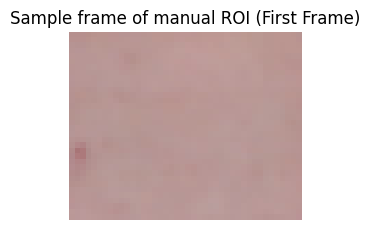

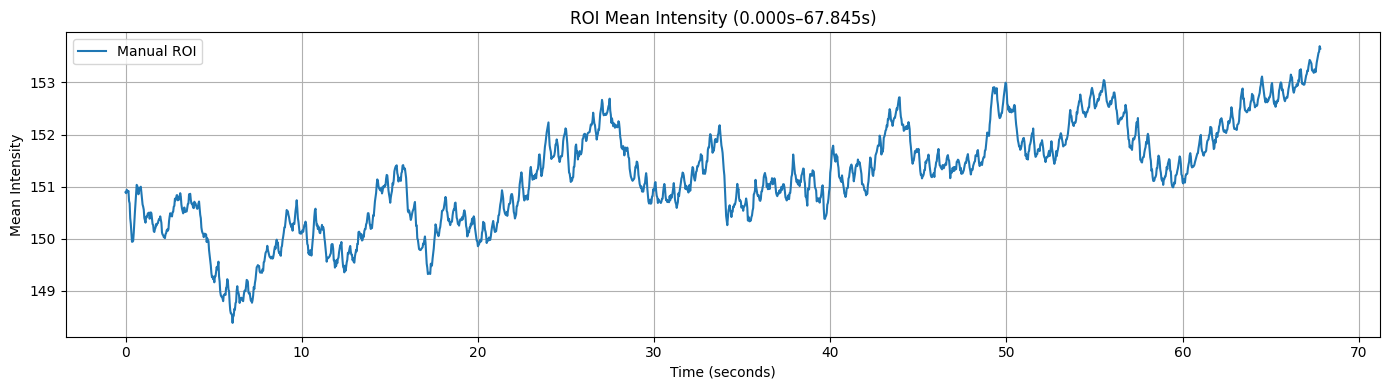

In [87]:
plt.figure(figsize=(3, 3))
plt.imshow(cv2.cvtColor(roi_frames_manual[0], cv2.COLOR_BGR2RGB))
plt.title(f"Sample frame of manual ROI (First Frame)")
plt.axis('off')
plt.show()

plt.figure(figsize=(14, 4))
plt.plot(np.arange(start_frame, start_frame + len(roi_means_manual)) / fps,
         roi_means_manual, label="Manual ROI")
plt.title(f"ROI Mean Intensity ({start_time:.3f}s–{end_time:.3f}s)")
plt.xlabel("Time (seconds)")
plt.ylabel("Mean Intensity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

2) Κανονικοποίηση (=> μ=0, σ=1) του σήματος μέσης έντασης για την αφαίρεση της DC συνιστώσας.

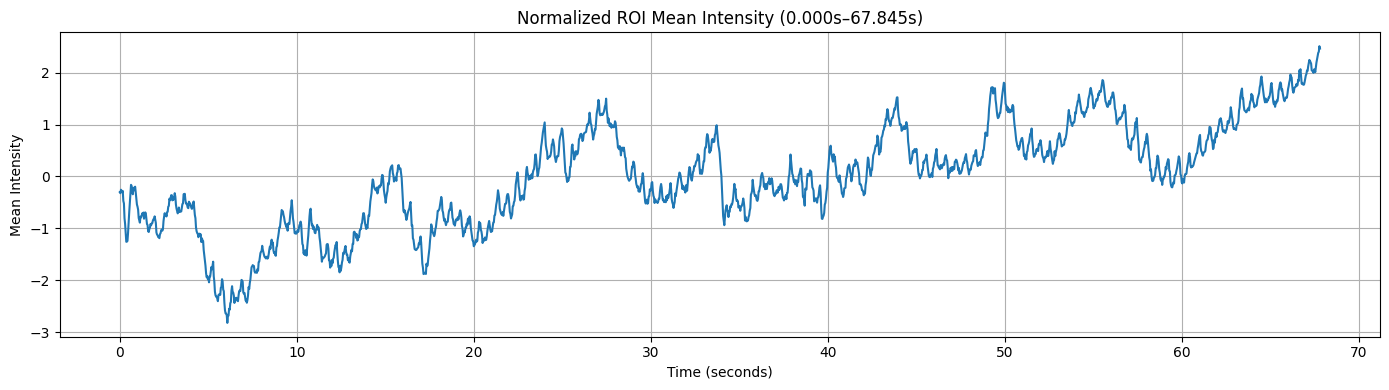

In [88]:
roi_mean_manual_norm = (roi_means_manual - np.mean(roi_means_manual)) / np.std(roi_means_manual)

plt.figure(figsize=(14, 4))
plt.plot(np.arange(int(start_time * fps), int(start_time * fps) + len(roi_means_manual)) / fps,
         roi_mean_manual_norm)
plt.title(f"Normalized ROI Mean Intensity ({start_time:.3f}s–{end_time:.3f}s)")
plt.xlabel("Time (seconds)")
plt.ylabel("Mean Intensity")
plt.grid(True)
plt.tight_layout()
plt.show()

3) Εφαρμογή Butterworth Ζωνοπερατού φίλτρου για την απομόνωση των δυνατών καρδιακών συχνοτήτων

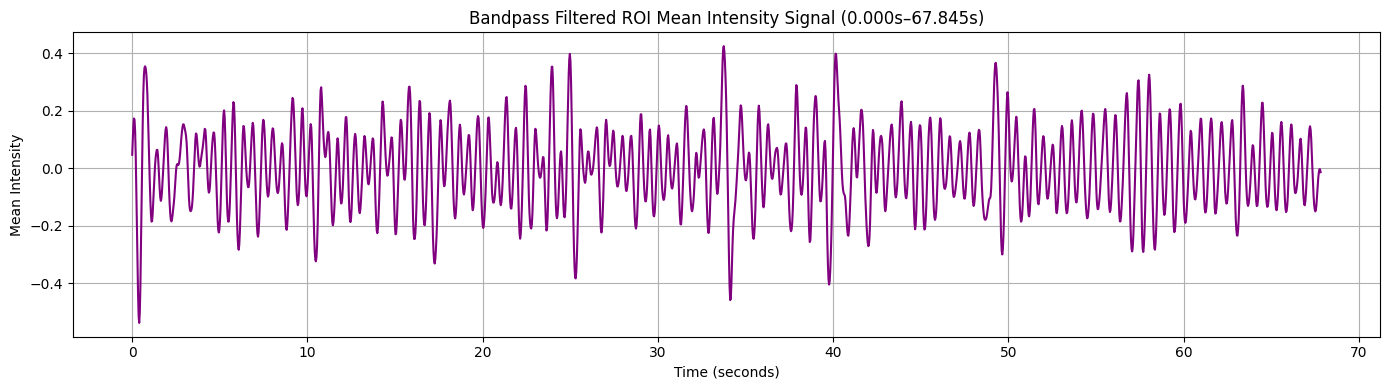

In [91]:
# Input the cutoff frequencies and the order of the bandpass filter.
# ----------------------
lowcut = 0.75
highcut = 2.5

filt_order=1
# ----------------------


def bandpass_filter(data, lowcut, highcut, fs, order=1):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)


filtered_manual = bandpass_filter(roi_mean_manual_norm, lowcut, highcut, fps, filt_order)

plt.figure(figsize=(14, 4))
plt.plot(np.arange(int(start_time * fps), int(start_time * fps) + len(roi_mean_manual_norm)) / fps,
         filtered_manual, color='purple')
plt.title(f"Bandpass Filtered ROI Mean Intensity Signal ({start_time:.3f}s–{end_time:.3f}s)")
plt.xlabel("Time (seconds)")
plt.ylabel("Mean Intensity")
plt.grid(True)
plt.tight_layout()
plt.show()

4) Εφαρμογή Short-Time-Fourier-Transform στο φιλτραρισμένο σήμα και οπτικοποίηση του μετασχηματισμού μέσω Spectogram. Εξαγαγωγή της κυρίαρχης συχνότητας από το κάθε χρονικό παράθυρο, μετατροπή από HZ σε bpm και αναπαράσταση σε γράφημα συγκριτικά με το HR του Ground Truth.

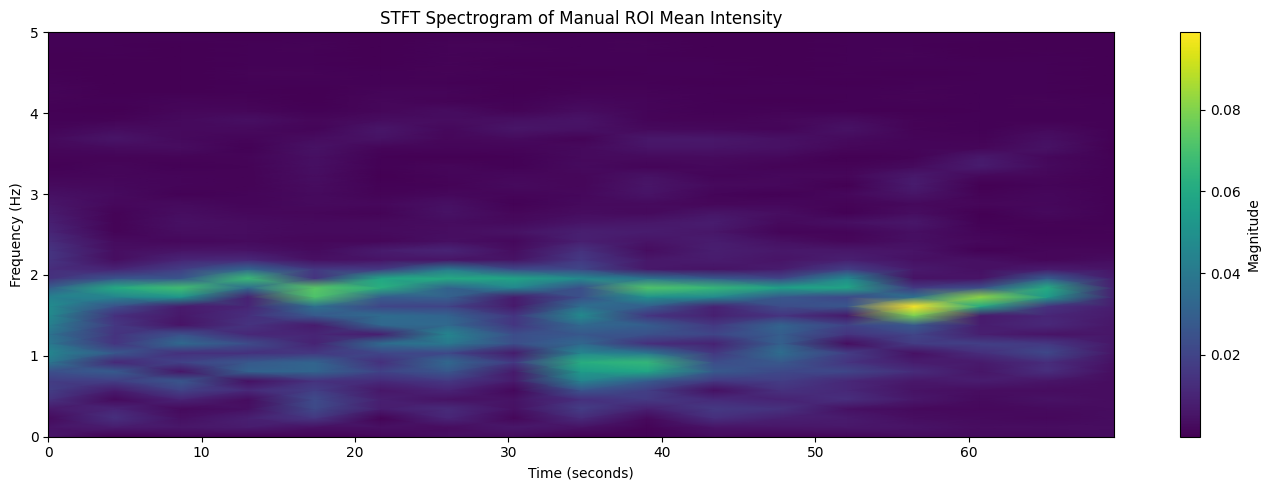

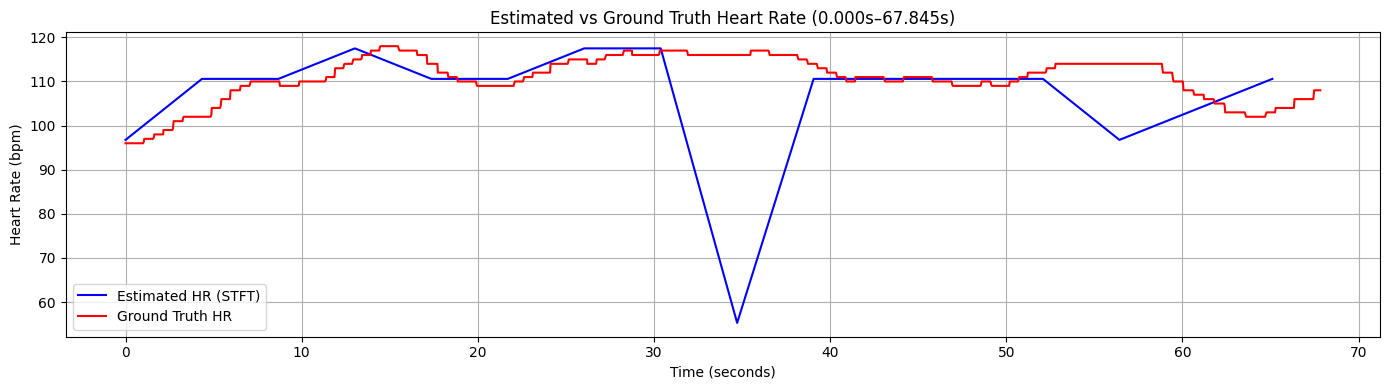

In [93]:
# Input the window parameters for the STFT
# ----------------------
window_size = 260
overlap_ratio = 0.5
# ----------------------



f_manual, t_manual, Zxx_manual = stft(filtered_manual,
                                      fs=fps,
                                      nperseg=window_size,
                                      noverlap= int(overlap_ratio * window_size),
                                      # boundary=None,
                                      # padded=False,
                                      )

t_manual = t_manual + start_time
magnitude_manual = np.abs(Zxx_manual)
dominant_freqs_manual = f_manual[np.argmax(magnitude_manual, axis=0)]
dominant_hr_manual = dominant_freqs_manual * 60  # Hz to bpm

valid_idx = t_manual <= end_time
t_manual_valid = t_manual[valid_idx]
dominant_hr_manual_valid = dominant_hr_manual[valid_idx]

start_samp = np.searchsorted(gt_time, start_time)
end_samp = np.searchsorted(gt_time, end_time)

plt.figure(figsize=(14, 5))
plt.pcolormesh(t_manual, f_manual, magnitude_manual, shading='gouraud')
plt.title("STFT Spectrogram of Manual ROI Mean Intensity")
plt.xlabel("Time (seconds)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label='Magnitude')
plt.ylim(0, 5)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 4))
plt.plot(t_manual_valid, dominant_hr_manual_valid, color='blue', label='Estimated HR (STFT)')
# plt.plot(t_manual, dominant_hr_manual, color='blue', label='Estimated HR (STFT)')
plt.plot(gt_time[start_samp:end_samp], gt_hr[start_samp:end_samp], color='red', label='Ground Truth HR')
plt.title(f"Estimated vs Ground Truth Heart Rate ({start_time:.3f}s–{end_time:.3f}s)")
plt.xlabel("Time (seconds)")
plt.ylabel("Heart Rate (bpm)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [72]:
print(dominant_hr_manual_valid)

[ 96.76358354 110.58695262 110.58695262 117.49863715 110.58695262
 110.58695262 117.49863715 117.49863715 117.49863715 110.58695262
 110.58695262 110.58695262 110.58695262  96.76358354 103.67526808
 110.58695262]


### **2ος Τρόπος:** Ορισμός ROI μέσω ανίχνευση προσώπου κατά Viola και Jones (Haar Cascades)

Εφαρμογή ανίχνευσης προσώπου κατά Viola και
Jones και επιλογή μέρους της εξόδου της ως ROI.

1) Εύρεση του Region of Interest (ROI) για κάθε frame του βίντεο. Υπολογισμός για κάθε frame της μέσης έντασης ενός χρωματικού καναλιού (πράσινο - G) μέσα στην ROI (Spatial Averaging) και αναπαράσταση σε γράφημα για ορισμένο παράθυρο χρόνου.

In [14]:
# Input start time and duration (in seconds) for Haar ROI Mean Channel intensity plot.
# Input the channel the calculations will be performed on.
# ----------------------
start_time = 5
segment_duration = 37 #video_duration_secs    # Signal lasts video_duration_secs seconds.

channel = 1  # 0: Blue, 1: Green, 2: Red  (BGR colorspace)
# ----------------------


end_time = start_time + segment_duration
start_time = np.clip(start_time, 0, video_duration_secs)
end_time = np.clip(end_time, 0, video_duration_secs)

start_frame = int(start_time * fps)
end_frame = int(end_time * fps)

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

face_frames_haar= []
roi_means_haar = []
roi_frames_haar =[]
print('Calculating ROI Mean Channel Intensity in all video frames...\n')


cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

for _ in tqdm(range(start_frame, end_frame)):
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=3, minSize=(60, 60))

    roi = []
    if len(faces) > 0:
        x, y, w, h = max(faces, key=lambda rect: rect[2] * rect[3])
        face_frames_haar.append(frame[y:y+h,x:x+w,:].copy())

        roi_x, roi_y, roi_w, roi_h = x+int(w*0.35), y+int(w*0.05), int(w*0.3), int(h*0.15)

        roi = frame[roi_y:roi_y+roi_h,roi_x:roi_x+roi_w,:].copy()
        roi_frames_haar.append(roi.copy())
        roi = roi[:,:,channel]

    else:
        face_frames_haar.append(None)

        roi = frame[y1:y2, x1:x2, :].copy()
        roi_frames_haar.append(roi.copy())

        roi = roi[:,:, channel]


    mean_val = np.mean(roi)
    roi_means_haar.append(mean_val)

cap.release()

print('\n\nCalculations completed!')

Calculating ROI Mean Channel Intensity in all video frames...



100%|██████████| 1061/1061 [00:48<00:00, 21.72it/s]



Calculations completed!


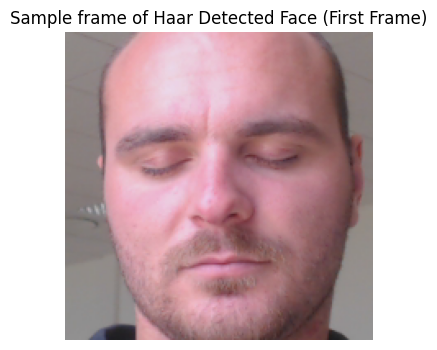

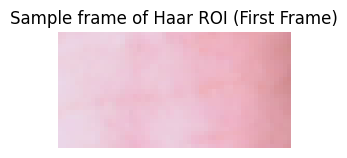

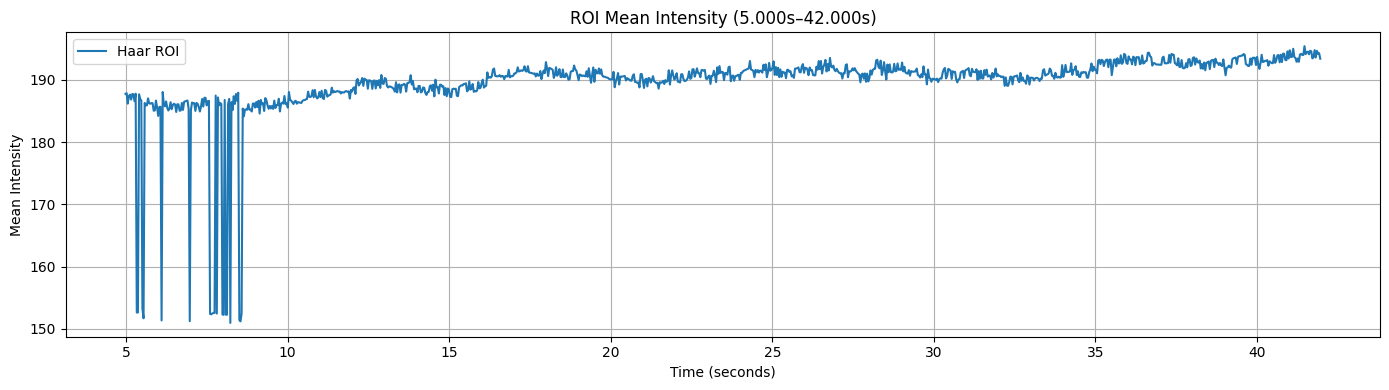

In [17]:
plt.figure(figsize=(6, 4))
plt.imshow(cv2.cvtColor(face_frames_haar[0], cv2.COLOR_BGR2RGB))
plt.title(f"Sample frame of Haar Detected Face (First Frame)")
plt.axis('off')
plt.show()

plt.figure(figsize=(3, 3))
plt.imshow(cv2.cvtColor(roi_frames_haar[0], cv2.COLOR_BGR2RGB))
plt.title(f"Sample frame of Haar ROI (First Frame)")
plt.axis('off')
plt.show()

plt.figure(figsize=(14, 4))
plt.plot(np.arange(start_frame, start_frame + len(roi_means_haar)) / fps,
         roi_means_haar, label="Haar ROI")
plt.title(f"ROI Mean Intensity ({start_time:.3f}s–{end_time:.3f}s)")
plt.xlabel("Time (seconds)")
plt.ylabel("Mean Intensity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

2) Κανονικοποίηση (=> μ=0, σ=1) του σήματος μέσης έντασης για την αφαίρεση της DC συνιστώσας.

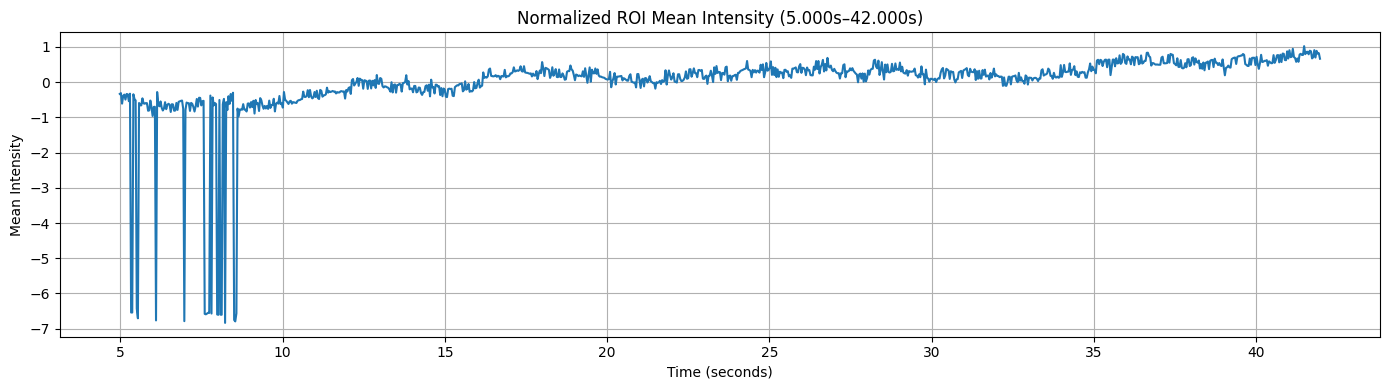

In [18]:
roi_mean_haar_norm = (roi_means_haar - np.mean(roi_means_haar)) / np.std(roi_means_haar)

plt.figure(figsize=(14, 4))
plt.plot(np.arange(int(start_time * fps), int(start_time * fps) + len(roi_means_haar)) / fps,
         roi_mean_haar_norm)
plt.title(f"Normalized ROI Mean Intensity ({start_time:.3f}s–{end_time:.3f}s)")
plt.xlabel("Time (seconds)")
plt.ylabel("Mean Intensity")
plt.grid(True)
plt.tight_layout()
plt.show()

### **3ος Τρόπος:** Ορισμός ROI μέσω ανίxνευσης προσώπου με Otsu thresholding

Εφαρμογή ανίχνευσης προσώπου μέσω Otsu thresholding και επιλογή μέρους της εξόδου της ως ROI

In [ ]:
testing=cv2.cvtColor(frame_bgr,cv2.COLOR_BGR2GRAY)

# Apply Otsu's thresholding
#Documentation in https://docs.opencv.org/4.x/d7/d1b/group__imgproc__misc.html#gae8a4a146d1ca78c626a53577199e9c57
otsu_thresh, thresh_im = cv2.threshold(testing, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
print("Optimal Threshold found at ",otsu_thresh)

plt.figure(figsize=(12, 12))
plt.imshow(thresh_im, cmap='gray')

### **------------------------------------------**

**2nd Implementation) SFT**

3) Fast Fourier Transform (for stable heart rate)

100%|██████████| 150/150 [00:00<00:00, 716.62it/s]


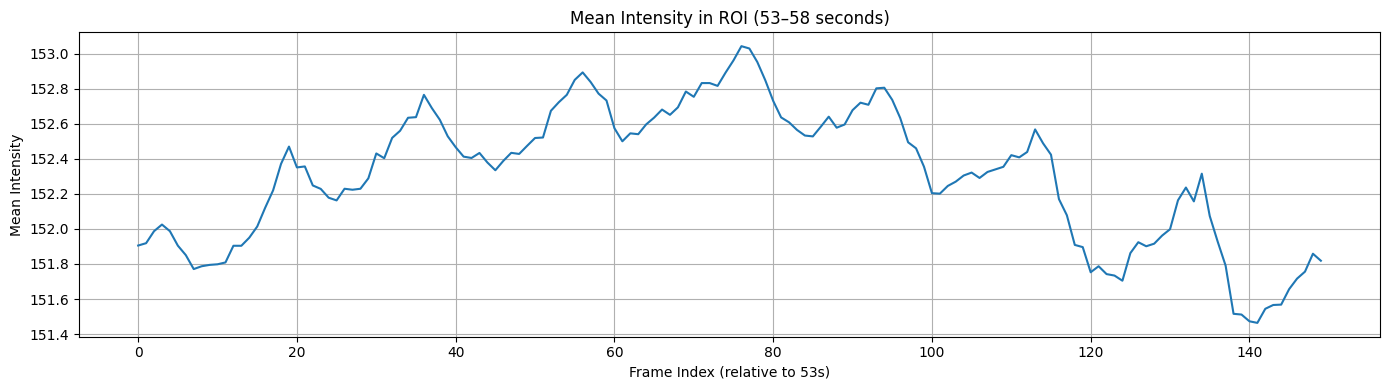

In [ ]:

# Reopen the video
cap = cv2.VideoCapture(video_path)

fps = cap.get(cv2.CAP_PROP_FPS)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Define time segment (in seconds)
start_time_sec = 53
end_time_sec = 58

# Convert time to frame indices
start_frame = int(start_time_sec * fps)
end_frame = int(end_time_sec * fps)

# Define ROI coordinates and color channel
y1, y2 = 141, 175
x1, x2 = 305, 347
channel = 1  # Green channel (BGR format)

roi_means = []

# Set video to start at the desired frame
cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

for _ in tqdm(range(start_frame, end_frame)):
    ret, frame = cap.read()
    if not ret:
        break

    roi = frame[y1:y2, x1:x2, channel]
    mean_val = np.mean(roi)
    roi_means.append(mean_val)

cap.release()

# Convert to NumPy array
roi_means = np.array(roi_means)

# Plot the ROI mean signal
plt.figure(figsize=(14, 4))
plt.plot(roi_means, label='ROI Mean (53–58s)')
plt.title("Mean Intensity in ROI (53–58 seconds)")
plt.xlabel("Frame Index (relative to 53s)")
plt.ylabel("Mean Intensity")
plt.grid(True)
plt.tight_layout()
plt.show()


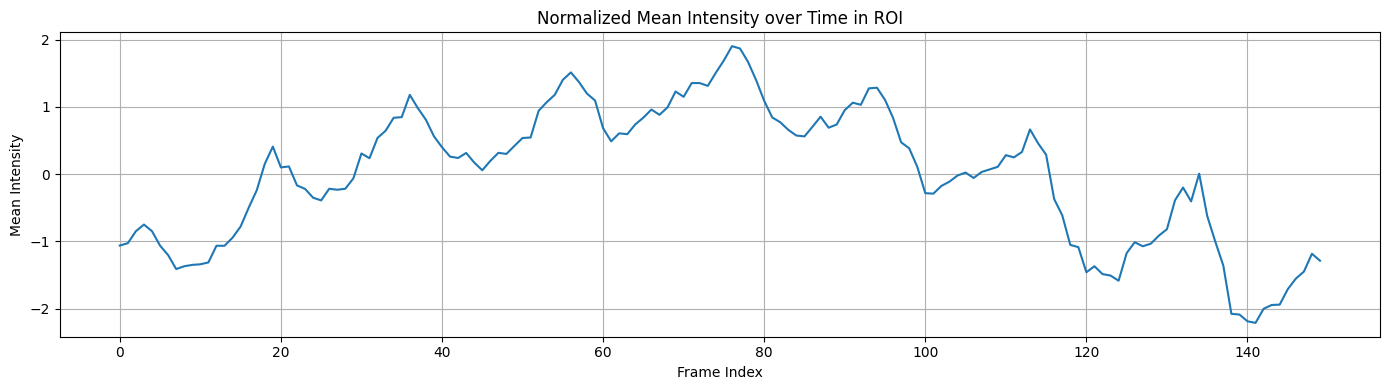

In [ ]:
roi_means_norm= (roi_means - np.mean(roi_means)) / np.std(roi_means)

plt.figure(figsize=(14, 4))
plt.plot(roi_means_norm, label='Normalized ROI Mean')
plt.title("Normalized Mean Intensity over Time in ROI")
plt.xlabel("Frame Index")
plt.ylabel("Mean Intensity")
plt.grid(True)
plt.tight_layout()
plt.show()

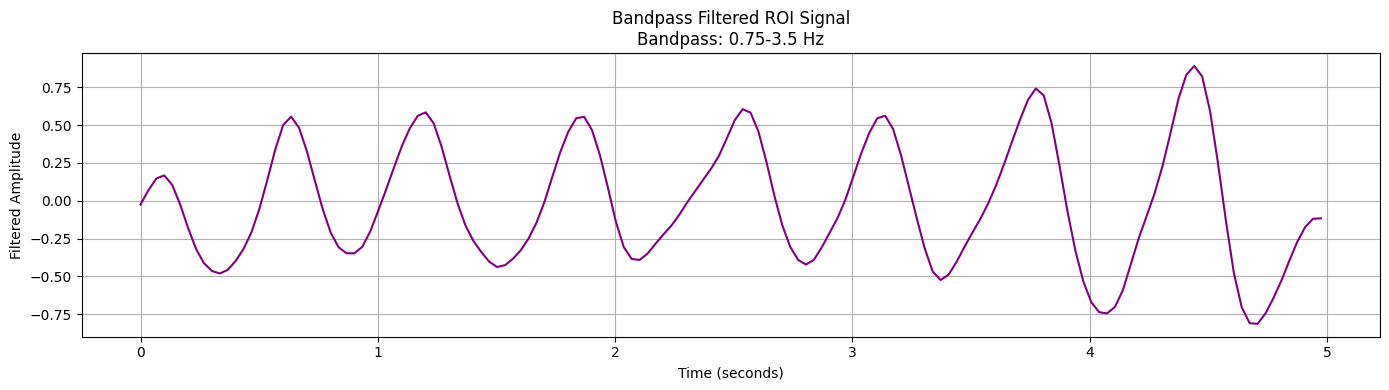

In [ ]:
fs = 29.951                # frame rate from video  # normalized ROI mean intensity

# --- Bandpass filter function ---
def bandpass_filter(data, lowcut, highcut, fs, order=1):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# --- Prepare indices ---
frame_count = len(roi_means_norm)
time = np.arange(frame_count) / fs


# --- Filter parameters ---
lowcut = 0.75   # Hz, approx. 45 bpm
highcut = 3.5   # Hz, approx. 210 bpm

# --- Apply bandpass filter on whole signal (optional) or on segment ---
filtered_signal = bandpass_filter(roi_means_norm, lowcut, highcut, fs, order=1)

# --- Plot filtered segment ---
plt.figure(figsize=(14, 4))
plt.plot(time, filtered_signal, color='purple')
plt.title(f"Bandpass Filtered ROI Signal\n"
          f"Bandpass: {lowcut}-{highcut} Hz")
plt.xlabel("Time (seconds)")
plt.ylabel("Filtered Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()


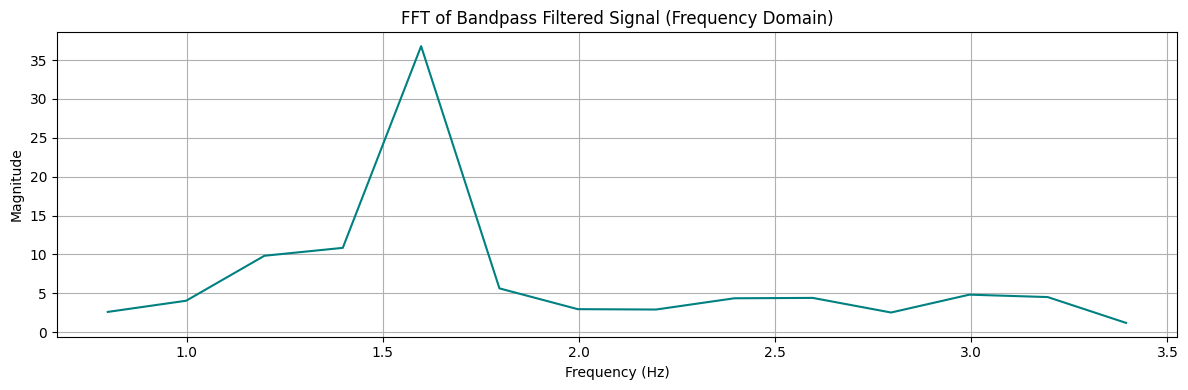

Estimated Heart Rate: 95.84 bpm


In [ ]:
# --- Extract only the filtered portion you're analyzing ---
segment = filtered_signal # roi_means_norm
n = len(segment)

# --- FFT ---
yf = fft(segment)
xf = fftfreq(n, d=1/fs)  # Frequency bins (Hz)

# --- Only keep positive frequencies ---
idxs = np.where(xf > 0)
xf = xf[idxs]
yf = np.abs(yf[idxs])

# --- Optional: focus on HR-relevant frequency band ---
mask = (xf >= 0.75) & (xf <= 3.5)
xf_hr = xf[mask]
yf_hr = yf[mask]

# --- Plot FFT spectrum ---
plt.figure(figsize=(12, 4))
plt.plot(xf_hr, yf_hr, color='teal')
plt.title("FFT of Bandpass Filtered Signal (Frequency Domain)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Estimate HR (in bpm) from peak frequency ---
peak_freq = xf_hr[np.argmax(yf_hr)]
heart_rate_bpm = peak_freq * 60
print(f"Estimated Heart Rate: {heart_rate_bpm:.2f} bpm")
